# Multi-GPU demo
pyclesperanto allows processing images on multiple GPUs in parallel. Therefore, you need to create multiple clesperanto/GPU handles, such as `cle1`, `cle2`, ...

In [2]:
from skimage.io import imread
import pyclesperanto as cle
import time
import numpy as np

In [3]:
cle.list_available_devices()

['NVIDIA GeForce RTX 2080 SUPER',
 'pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz']

In [4]:
d1 = cle.select_device(device_name="TX")
d2 = cle.select_device(device_name="Intel")

In [5]:
print(d1.info)
print(d2.info)

(OpenCL) NVIDIA GeForce RTX 2080 SUPER (OpenCL 3.0 CUDA)
	Type: GPU
	Compute Units: 48
	Global Memory Size: 8358 MB
	Maximum Object Size: 2089 MB

(OpenCL) pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz (OpenCL 1.2 pocl HSTR: pthread-x86_64-pc-linux-gnu-skylake-avx512)
	Type: CPU
	Compute Units: 16
	Global Memory Size: 98765 MB
	Maximum Object Size: 34359 MB



## Using multiple GPUs sequentially
As you can see above, these two handles represent different GPUs, from NVidia and AMD. You can use these two handles by calling operations on them as usual for just showing images ...

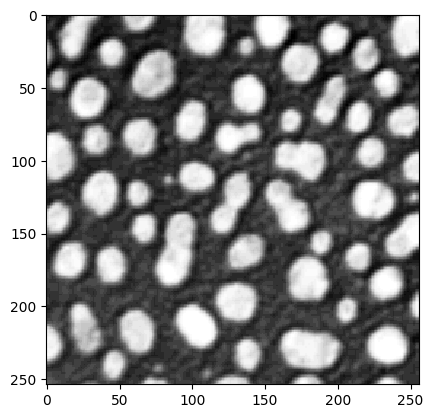

In [6]:
image = imread("https://samples.fiji.sc/blobs.png").squeeze()

cle.imshow(image)

... and for executing operations on the respective GPU.

In [7]:
image1 = cle.push(image, device=d1)
image2 = cle.push(image, device=d2)

In [8]:
blurred1 = cle.gaussian_blur(image1, sigma_x=10)
blurred2 = cle.gaussian_blur(image2, sigma_y=5)

array([[ 40.09867 ,  41.156883,  42.50785 , ..., 189.27463 , 192.13885 ,
        194.54205 ],
       [ 50.640034,  51.278248,  52.21751 , ..., 202.75035 , 205.77882 ,
        208.34549 ],
       [ 56.174618,  56.58758 ,  57.299023, ..., 214.51335 , 217.79279 ,
        220.61713 ],
       ...,
       [ 69.127556,  68.62755 ,  68.08486 , ...,  63.774857,  61.41017 ,
         59.30248 ],
       [ 73.34248 ,  72.481384,  71.57082 , ...,  68.13706 ,  65.15866 ,
         62.496014],
       [ 82.46705 ,  81.12341 ,  79.76445 , ...,  72.53829 ,  69.04784 ,
         65.90595 ]], dtype=float32, mtype=buffer)
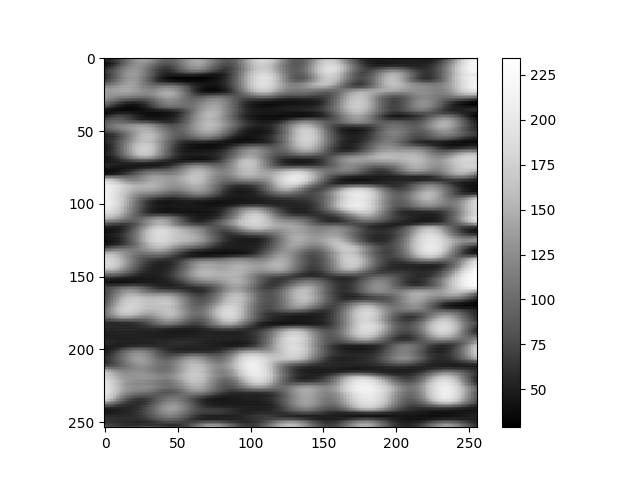
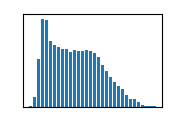

In [9]:
blurred1

array([[ 40.902157,  35.52846 ,  28.57356 , ..., 225.07469 , 212.74393 ,
        212.74393 ],
       [ 40.747154,  36.183662,  29.756958, ..., 226.44623 , 214.88696 ,
        214.88696 ],
       [ 40.56795 ,  36.867207,  31.014427, ..., 227.67151 , 216.88551 ,
        216.88551 ],
       ...,
       [ 76.24275 ,  76.0747  ,  72.87161 , ...,  47.891773,  49.0616  ,
         49.0616  ],
       [ 79.0909  ,  77.96501 ,  74.195816, ...,  47.92384 ,  48.865387,
         48.865387],
       [ 81.93995 ,  79.80999 ,  75.43991 , ...,  47.94881 ,  48.678448,
         48.678448]], dtype=float32, mtype=buffer)
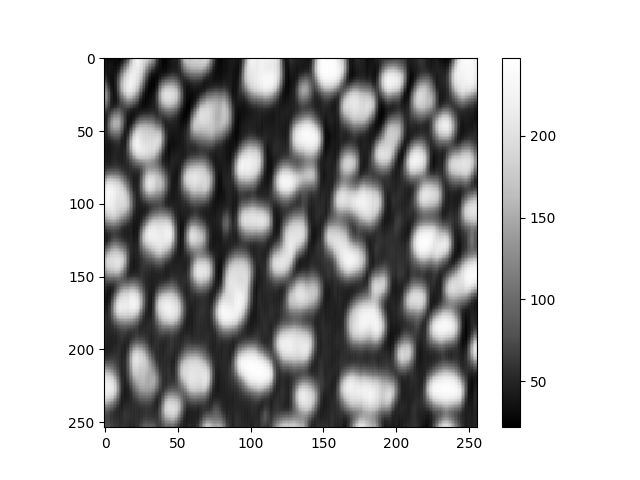
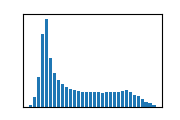

In [10]:
blurred2

Just for visualization purposes, we again print put the name of the GPU device that is used under the hood.

For demonstration purposes, we will execute a Gaussian blur with a wide radius on a large image. We will see that this operation takes some time on the individual GPUs.

In [11]:
# create a 100 MB test image
test_image = np.random.random((10, 1000, 1000)).astype(float)

# push the image to memory of both GPUs.
image1 = cle.push(test_image, device=d1)
image2 = cle.push(test_image, device=d2)

# we wait here for a second to make sure the images arrived
time.sleep(1)

In [12]:
image1.shape, image2.shape

((10, 1000, 1000), (10, 1000, 1000))

We now execute the Gaussian blur on both GPUs sequentially a couple of times and measure the time it takes.

In [13]:
for i in range(0, 5):
    print("-------------")
    start_time = time.time()
    
    # process image on first GPU
    blurred1 = cle.gaussian_blur(image1, sigma_x=20 + i, sigma_y=20 + i)
    # retrieve result from first GPU
    result1 = cle.pull(blurred1)
    print("Processing and pulling on", d1.name, "took", time.time() - start_time)
    
    start_time = time.time()
    # process image on second GPU
    blurred2 = cle.gaussian_blur(image2, sigma_x=20 + i, sigma_y=20 + i)
    # retrieve result from second GPU
    result2 = cle.pull(blurred2)
    print("Processing and pulling on", d2.name, "took", time.time() - start_time)
    
    

-------------
Processing and pulling on NVIDIA GeForce RTX 2080 SUPER took 0.12221980094909668
Processing and pulling on pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz took 4.769605875015259
-------------
Processing and pulling on NVIDIA GeForce RTX 2080 SUPER took 0.030371904373168945
Processing and pulling on pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz took 4.554941177368164
-------------
Processing and pulling on NVIDIA GeForce RTX 2080 SUPER took 0.030538082122802734
Processing and pulling on pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz took 4.86421799659729
-------------
Processing and pulling on NVIDIA GeForce RTX 2080 SUPER took 0.0307767391204834
Processing and pulling on pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz took 5.0870606899261475
-------------
Processing and pulling on NVIDIA GeForce RTX 2080 SUPER took 0.0318145751953125
Processing and pulling on pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz took 5.344726085662842


You can clearly see that the one device is a bit slower than the other. We now repeat that experiment with a different call-order. If processing is done in parallel in the background, we will see that the processing time of each for-loop iteration is less than in the example above. 

In [14]:
for i in range(0, 5):
    print("-------------")
    start_time = time.time()
    
    # process image on both GPUs
    blurred1 = cle.gaussian_blur(image1, sigma_x=20 + i, sigma_y=20 + i)
    blurred2 = cle.gaussian_blur(image2, sigma_x=20 + i, sigma_y=20 + i)

    # retrieve result from both GPUs
    result1 = cle.pull(blurred1)
    result2 = cle.pull(blurred2)
    print("Processing and pulling on", d1.name, "and", d2.name, "in parallel took", time.time() - start_time)

-------------
Processing and pulling on NVIDIA GeForce RTX 2080 SUPER and pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz in parallel took 4.423760890960693
-------------
Processing and pulling on NVIDIA GeForce RTX 2080 SUPER and pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz in parallel took 4.771919012069702
-------------
Processing and pulling on NVIDIA GeForce RTX 2080 SUPER and pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz in parallel took 4.902347087860107
-------------
Processing and pulling on NVIDIA GeForce RTX 2080 SUPER and pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz in parallel took 5.0963194370269775
-------------
Processing and pulling on NVIDIA GeForce RTX 2080 SUPER and pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz in parallel took 5.304725408554077


we can now run different kernels on different devices at the same time. 
  
Enjoy!